In [2]:
import numpy as np
import pandas as pd
import pickle
from statistics import mode
import nltk
from nltk import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,Attention
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
# import pydot-ng as pydot

In [3]:
import tensorflow as tf

In [4]:
df=pd.read_csv("Reviews.csv", nrows=100000)
df.drop_duplicates(subset=["Text"], inplace=True)   # Removes duplicate data
df.dropna(axis=0, inplace=True)                     # Removes Null values
input_data = df.loc[:, "Text"]
target_data = df.loc[:, "Summary"]
target_data.replace('', np.nan, inplace=True)

In [5]:
input_texts = []
target_texts = []
input_words = []
target_words = []
contractions=pickle.load(open("contractions.pkl","rb"))['contractions']
stop_words = stopwords.words('english')
stemmer = LancasterStemmer()

In [6]:
def clean(texts, src):
    # Removing the HTML tags present in the text using Beautiful Soup
    texts = BeautifulSoup(texts, "lxml").text      # https://www.pluralsight.com/guides/extracting-data-html-beautifulsoup
    
    # Tokenizing the reviews and converting into lowercase
    words = word_tokenize(texts.lower())
    
    # Filtering words containing numbers and words with length less than 3
    words = list(filter(lambda w: (w.isalpha() and len(w)>=3), words))   # Because filter returns a filter object not a list
    
    # Expansion of shortened words from the contractions dictionary
    words = [contractions[w] if w in contractions else w for w in words]
    
   # Stemming of words and removal of stopwords
    if src=="inputs":
        words = [stemmer.stem(w) for w in words if w not in stop_words]
        
    else:
        words = [w for w in words if w not in stop_words]
        
    return words

In [7]:
for in_txt, tr_txt in zip(input_data, target_data):
    in_words = clean(in_txt, "inputs")
#     print(in_words)
    input_texts += [' '.join(in_words)]
#     print("----------------------------------------------------")
#     print(input_texts)
    input_words += in_words
#     print("----------------------------------------------------")
#     print(input_words)
    
    tr_words = clean("sos " + tr_txt + " eos", "target")
#     print(tr_words)
    target_texts += [' '.join(tr_words)]
#     print(target_texts)
    target_words += tr_words
#     print(target_words)

C:\Users\Aditya Agarwal\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [8]:
clean("That man has changed for good because he gained the knowledge of being happy in whatever he has rather than lamenting for what you don't have", "inputs")

['man', 'chang', 'good', 'gain', 'knowledg', 'happy', 'whatev', 'rath', 'lam']

In [9]:
frequency = nltk.FreqDist(target_words)
frequency.pop('sos')
frequency.pop('eos')
frequency

FreqDist({'great': 11266, 'good': 8198, 'best': 5007, 'love': 4122, 'coffee': 3394, 'tea': 3254, 'product': 2999, 'delicious': 2880, 'taste': 2754, 'dog': 2315, ...})

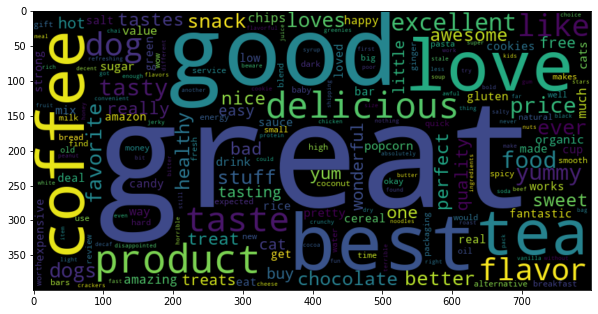

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(frequency)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('on')
plt.show()

In [11]:
# Sorting and Removing Duplicate words
input_words = sorted(list(set(input_words)))
target_words = sorted(list(set(target_words)))
num_input_words = len(input_words)
num_target_words = len(target_words)

# Length of the words which appear more often (Mode of the length of the words)
max_input_len = mode([len(i) for i in input_texts])
max_target_len = mode([len(i) for i in target_texts])

print("Number of input words: ", num_input_words)
print("Number of target words: ", num_target_words)
print("Maximum input length: ", max_input_len)
print("Maximum target length: ", max_target_len)

Number of input words:  32198
Number of target words:  14170
Maximum input length:  74
Maximum target length:  17


In [12]:
x_train, x_test, y_train, y_test = train_test_split(input_texts, target_texts, test_size = 0.2, random_state = 0)
# print(y_train)

In [13]:
input_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(x_train)
target_tokenizer = Tokenizer()
target_tokenizer.fit_on_texts(y_train)
x_train = input_tokenizer.texts_to_sequences(x_train)
y_train = target_tokenizer.texts_to_sequences(y_train)

In [14]:
enc_input_data = pad_sequences(x_train, maxlen = max_input_len, padding = 'post')

#decoder input data will not include the last word i.e. 'eos' in decoder input data

dec_input_data = [x[:-1] for x in y_train]
dec_input_data = pad_sequences(dec_input_data, maxlen = max_target_len, padding = 'post')
# print(dec_input_data.shape)


#decoder target data will be one time step ahead as it will not include the first word i.e 'sos'

dec_data= pad_sequences(y_train,  maxlen = max_target_len, padding = 'post')
dec_target_data = dec_data[:,1:]

# print(dec_data.shape)
# print(dec_data[0])

dec_target_data= pad_sequences(dec_target_data,  maxlen = max_target_len, padding = 'post')

# print(dec_target_data.shape)
# print(dec_target_data[0])

dec_target_data = dec_target_data.reshape(len(dec_data),max_target_len,1)
# print(dec_target_data.shape)

In [15]:
print(num_input_words)

32198


In [16]:
K.clear_session()
latent_dim = 500
# Latent space refers to an abstract multi-dimensional space containing feature values that we cannot interpret directly, but which encodes a meaningful internal representation of externally observed events.

encoder_inputs = Input(shape = (max_input_len,))
# print(encoder_inputs)
#Input() is used to instantiate a Keras tensor.
# A Keras tensor is a symbolic tensor-like object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model.

encoder_embedding = Embedding(num_input_words+1, latent_dim)(encoder_inputs)

In [17]:
# 3 stacked LSTM layers with the shape of hidden dimension

# LSTM1
en_lstm1 = LSTM(latent_dim, return_state = True, return_sequences = True)
en_outputs1, state_h1, state_c1 = en_lstm1(encoder_embedding)

# LSTM2
en_lstm2 = LSTM(latent_dim, return_state = True, return_sequences = True)
en_outputs2, state_h2, state_c2 = en_lstm2(en_outputs1)

# LSTM3
en_lstm3 = LSTM(latent_dim, return_state = True, return_sequences = True)
en_outputs3, state_h3, state_c3 = en_lstm3(en_outputs2)

encoder_states = [state_h3, state_c3]

In [18]:
# Decoder
decoder_inputs = Input(shape = (None,))
decoder_embedding = Embedding(num_target_words + 1, latent_dim)(decoder_inputs)


decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs, *_ = decoder_lstm(decoder_embedding, initial_state = encoder_states)

In [19]:
# Attention Layer
attention = Attention()([decoder_outputs, en_outputs3])

# Concatenate the attention output with the decoder outputs
merge = Concatenate(axis = -1, name = 'concat_layer1')([decoder_outputs, attention])

In [20]:
# Dense Layer(Ouput Layer)
dense = Dense(num_target_words+1, activation = "softmax")
final_decoder_outputs = dense(merge)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 500)      16099500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 74, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

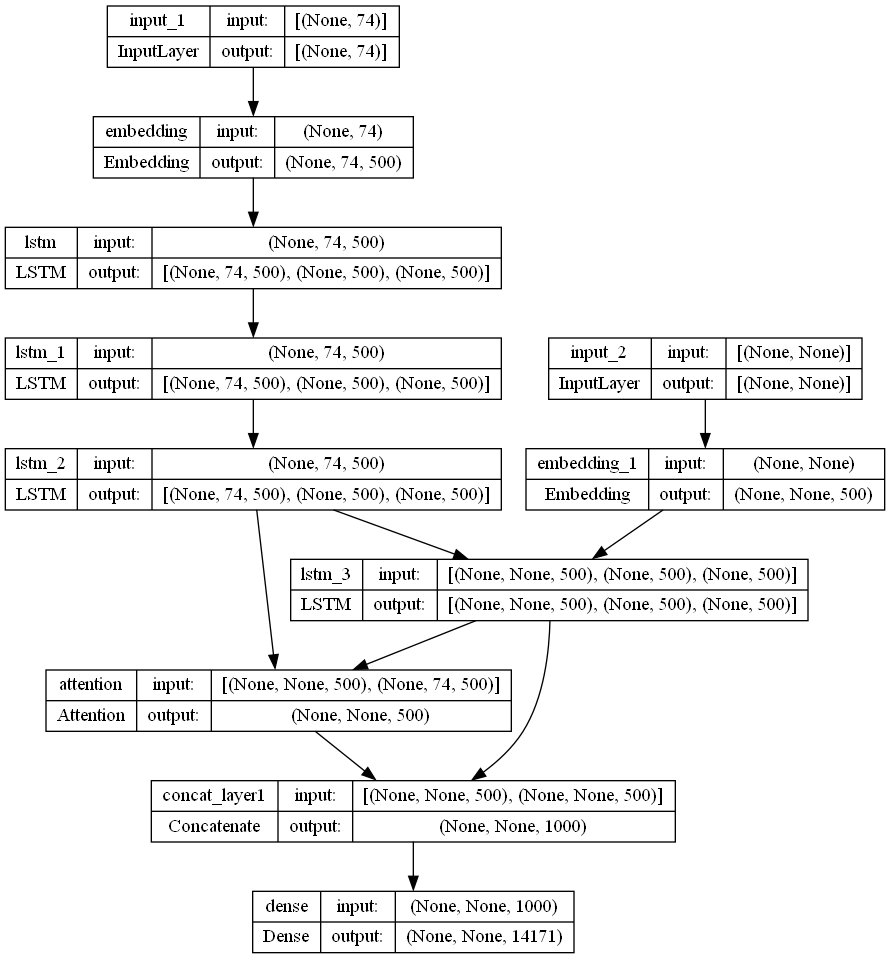

In [21]:
model = Model([encoder_inputs, decoder_inputs], final_decoder_outputs)
model.summary()
plot_model(model, to_file = "model_plot.png", show_shapes = True, show_layer_names = True)

In [22]:
# model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model.fit(
    [enc_input_data, dec_input_data],
    dec_target_data,
    batch_size = 512,
    epochs = 10,
    validation_split = 0.1,
)

In [23]:
# model.save("s2s")
# model.save("text_summ.h5")

In [24]:
# encoder inference
latent_dim=500

#load the model
model = models.load_model("s2s")

In [25]:
#construct encoder model from the output of 6 layer i.e.last LSTM layer
en_outputs,state_h_enc,state_c_enc = model.layers[6].output
en_states=[state_h_enc,state_c_enc]

#add input and state from the layer.
en_model = Model(model.input[0],[en_outputs]+en_states)

In [26]:
model.layers

In [27]:
# Decoder Inference
decoder_state_input_hidden = Input(shape=(latent_dim))
decoder_state_input_cell = Input(shape=(latent_dim))

dec_inputs = model.input[1]
dec_emb_layer = model.layers[5]
decoder_lstm = model.layers[7]
decoder_embedding = dec_emb_layer(dec_inputs)

decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding, initial_state=[decoder_state_input_hidden, decoder_state_input_cell])

In [28]:
# Attention Layer
dec_hidden_state_input = Input(shape=(max_input_len, latent_dim))

attention = model.layers[8]
attention_output = attention([decoder_outputs2, dec_hidden_state_input])

merge2 = Concatenate(axis=-1)([decoder_outputs2, attention_output])

In [29]:
# Desnse Layer
decoder_dense = model.layers[10]
decoder_outputs2 = decoder_dense(merge2)

decoder_model = Model([dec_inputs] + [dec_hidden_state_input, decoder_state_input_hidden, decoder_state_input_cell], 
                     [decoder_outputs2] + [state_h2, state_c2])

In [43]:
reverse_target_word_index = target_tokenizer.index_word
# print(reverse_target_word_index)
reverse_source_word_index = input_tokenizer.index_word
# print(reverse_source_word_index)

target_word_index = target_tokenizer.word_index
# print(target_word_index)
reverse_target_word_index[0] = " "

def decode_sequence(input_seq):
    #Getting the encoder output and states by passing the input sequence
    en_out, en_h, en_c = en_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_word_index['sos']
    
    #If the iteration reaches the end of text than it will be stop the iteration
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_words, dec_h, dec_c = decoder_model.predict([target_seq] + [en_out, en_h, en_c])
#         print(np.argmax(output_words[0, -1, :]))
#         print(output_words[0, -1, :])
#         print(output_words.shape)
        word_index = np.argmax(output_words[0, -1, :])
#         print(word_index)
        text_word = reverse_target_word_index[word_index]
#         print(text_word)
        decoded_sentence += text_word + " "
#         print(decoded_sentence)
        
        if text_word == "eos" or len(decoded_sentence) > max_target_len:
            stop_condition = True
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = word_index
        en_h, en_c = dec_h, dec_c
    return decoded_sentence

In [70]:
input_text = input("Enter the text to be summarized: ")
# print("Input Text: ", input_text)
input_text = clean(input_text, "inputs")
# print(input_text)
input_text = " ".join(input_text)
# print(input_text)
input_x = input_tokenizer.texts_to_sequences([input_text])
# print(input_x)
input_x = pad_sequences(input_x, maxlen=max_input_len, padding='post')

# print(input_x.shape)

summary = decode_sequence(input_x)

if "eos" in summary:
    summary = summary.replace("eos", "")

print("Summary: ", summary)

Enter the text to be summarized: The product is likely not as good as ealier one
1/1 [==============================] - 0s 39ms/step
Summary:  good stuff  
